# Supervised Machine Learning: Regression and Classification

In [16]:
import sys
sys.path.insert(0, './work/machine_learning/01 - supervised_ml_regression_classification')

import matplotlib.pyplot as plt

from lab_utils_uni import plt_intuition, plt_stationary, plt_update_onclick, soup_bowl

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, unix_timestamp, col, regexp_replace
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
import pyspark.pandas as ps
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline

import numpy as np
import math

## Pyspark config

In [2]:
# SPAWN A SPARKSESSION
spark = SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.cores", "12").\
        config("spark.executor.memory", "1024mb").\
        getOrCreate()

In [5]:
# Read dataset for this course and cache() it

df = ps.read_csv("hdfs://namenode:9000/data/cardio_base.csv", index_col="id")
df = df.astype(int)

df = ps.get_dummies(df, columns=['gender', 'smoke'], dtype='int', )

df = df.loc[df['ap_hi'] < 500]

# Why cache dataframe?
# Reusing Data: Caching is optimal when you need to perform multiple operations on the same dataset to 
#    avoid reading from storage repeatedly.
# Frequent Subset Access: Useful for frequently accessing small subsets of a large dataset, reducing the 
#    need to load the entire dataset repeatedly.
df_cached = df.spark.cache()

df_cached.head(10)

,age,height,weight,ap_hi,ap_lo,cholesterol,gender_1,gender_2,smoke_0,smoke_1
id,,,,,,,,,,
0,18393,168,62,110,80,1,0,1,1,0
1,20228,156,85,140,90,3,1,0,1,0
2,18857,165,64,130,70,3,1,0,1,0
3,17623,169,82,150,100,1,0,1,1,0
4,17474,156,56,100,60,1,1,0,1,0
8,21914,151,67,120,80,2,1,0,1,0
9,22113,157,93,130,80,3,1,0,1,0
12,22584,178,95,130,90,3,0,1,1,0
13,17668,158,71,110,70,1,1,0,1,0


## Week 2

### Multiple Linear Regression

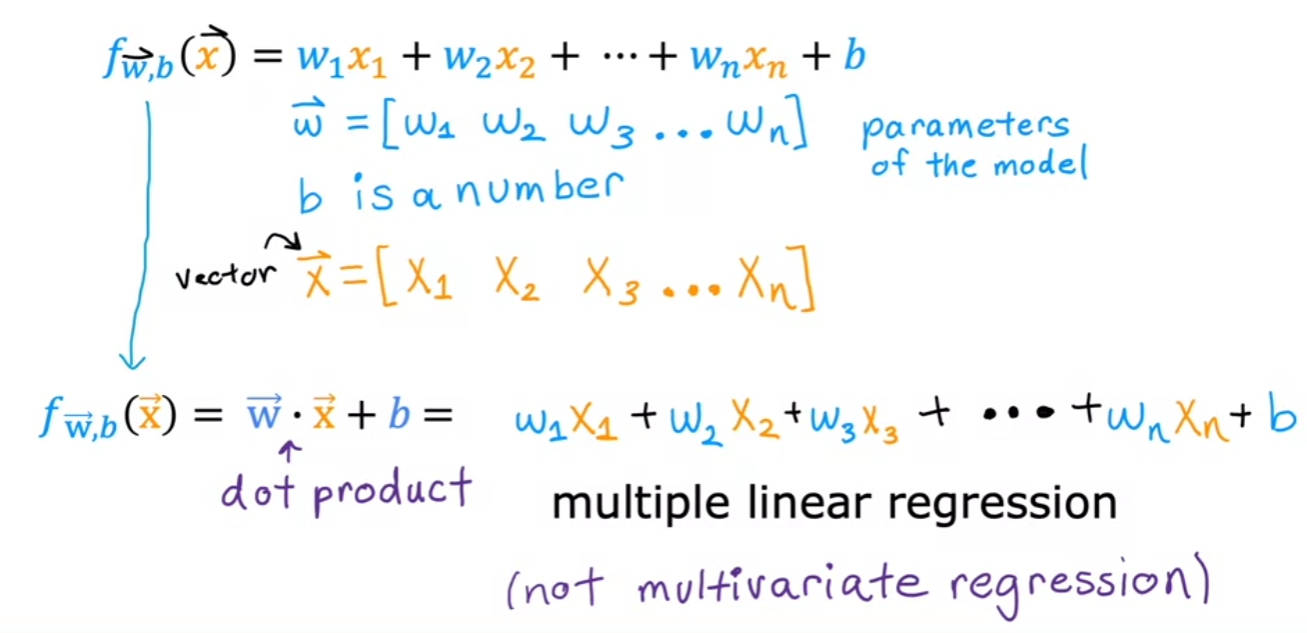

- Calculating a multiple element linear function can be done in a vectorized manner to run in parallel in the processor
- Calculating the Gradient Descent for multiple linear regression can also be done in a vectorized manner

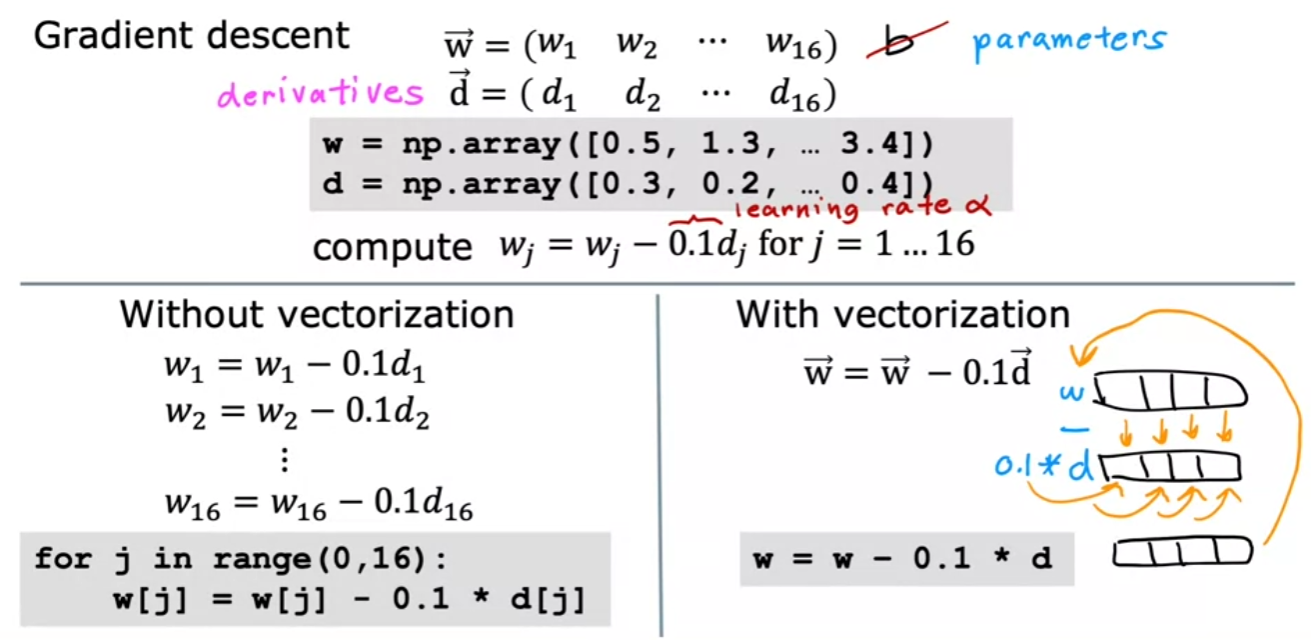

$
\text{Repeat until convergence } \{ 
\\
w_j = w_j - \alpha \frac{1}{m} \sum_{i=0}^{m-1} ((f_{\vec{w},b}(x^{(i)}) - y^{(i)}) \cdot x_j^{(i)})
\\
 b := b - \alpha \frac{1}{m} \sum\limits_{i=0}^{m-1} (f_{\vec{w},b}(x^{(i)}) - y^{(i)}) 
\\
\}
$



##### Learning Rate

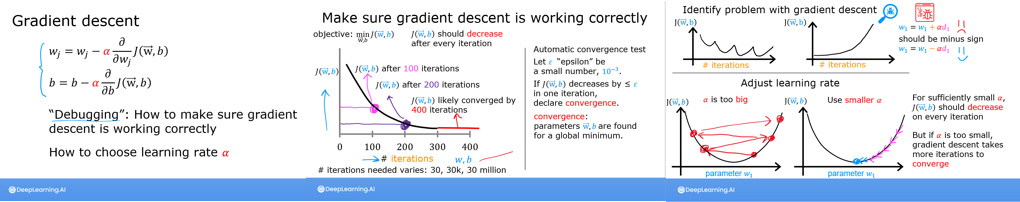

##### Implementation of Multiple Linear Regression w/o MinMaxScaling in Spark using pyspark.pandas API

In [7]:
# LINEAR REGRESSION AGE IN DAYS AND WEIGHT TO PREDICT SYSTOLIC BLOOD PRESSURE
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

sampled_df = df_cached.sample(frac=0.1)

# Convert pandas dataframe to Spark dataframe
spark_df = sampled_df.to_spark()

/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [62]:
# Create a vector assembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=["age", "weight"], outputCol="features")

# Transform the dataframe using the vector assembler
assembled_df = assembler.transform(spark_df)

# Split the data into a training and test set
train_ratio = 0.8
test_ratio = 1 - train_ratio

train_df, test_df = assembled_df.randomSplit([train_ratio, test_ratio], seed=42)

# Create a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="ap_hi", solver="l-bfgs")

# Fit the model to the data
lr_model = lr.fit(train_df)

print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

pred = lr_model.transform(test_df)
pred.show(10)

# Create a RegressionEvaluator object
evaluator = RegressionEvaluator(labelCol="ap_hi", predictionCol="prediction")


# Calculate RMSE
rmse = evaluator.evaluate(pred, {evaluator.metricName: "rmse"})

# Calculate MSE
mse = evaluator.evaluate(pred, {evaluator.metricName: "mse"})

# Calculate MAE
mae = evaluator.evaluate(pred, {evaluator.metricName: "mae"})

# Calculate R2
r2 = evaluator.evaluate(pred, {evaluator.metricName: "r2"})

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

Coefficients: [0.0012996754182117555,0.3326044408575792]
Intercept: 76.1331864440323
+-----+------+------+-----+-----+-----------+--------+--------+-------+-------+---------------+------------------+
|  age|height|weight|ap_hi|ap_lo|cholesterol|gender_1|gender_2|smoke_0|smoke_1|       features|        prediction|
+-----+------+------+-----+-----+-----------+--------+--------+-------+-------+---------------+------------------+
|14302|   153|    57|  100|   60|          1|       1|       0|      1|      0| [14302.0,57.0]|113.67959740417885|
|14326|   162|    70|  110|   70|          1|       1|       0|      1|      0| [14326.0,70.0]|118.03464734536445|
|14332|   160|   110|  120|   80|          1|       0|       1|      0|      1|[14332.0,110.0]| 131.3466230321769|
|14352|   162|    72|  110|   70|          1|       1|       0|      1|      0| [14352.0,72.0]|118.73364778795312|
|14365|   168|    64|   11|   60|          1|       0|       1|      0|      1| [14365.0,64.0]|116.08970804152

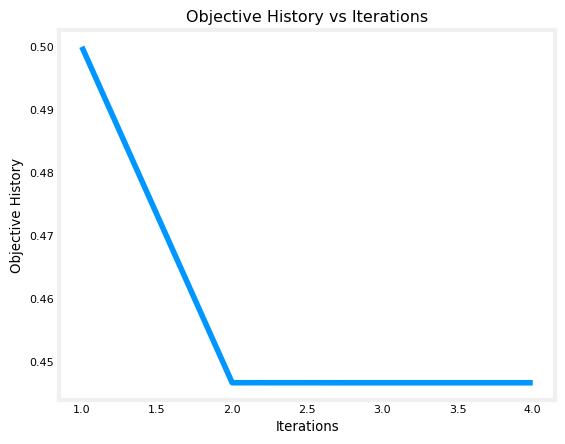

In [63]:
# Get the objective history from the lr_model summary
objective_history = lr_model.summary.objectiveHistory

# Create a list of iterations
iterations = list(range(1, len(objective_history) + 1))

plt.plot(iterations, objective_history)
plt.xlabel('Iterations')
plt.ylabel('Objective History')
plt.title('Objective History vs Iterations')
plt.show()


##### Implementation of Multiple Linear Regression w/ MinMaxScaling in Spark using pyspark.pandas API

Feature scaling standardizes all features to one scale and can help algorithms converge quicker

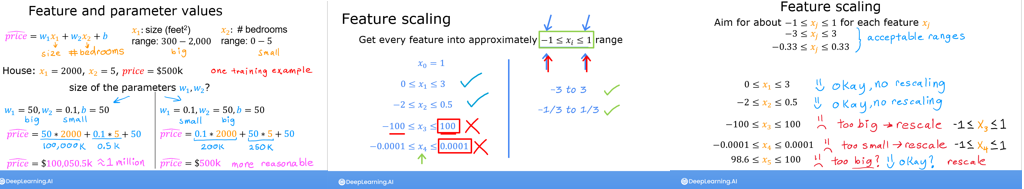

In [20]:
# Create the scaler object
columns_to_scale = ["age", "weight"]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalers_model = pipeline.fit(spark_df)
scaled_df = scalers_model.transform(spark_df)

# Show the scaled DataFrame
scaled_df.show(10)

+-----+------+------+-----+-----+-----------+--------+--------+-------+-------+---------+----------+--------------------+--------------------+
|  age|height|weight|ap_hi|ap_lo|cholesterol|gender_1|gender_2|smoke_0|smoke_1|  age_vec|weight_vec|          age_scaled|       weight_scaled|
+-----+------+------+-----+-----+-----------+--------+--------+-------+-------+---------+----------+--------------------+--------------------+
|17623|   169|    82|  150|  100|          1|       0|       1|      1|      0|[17623.0]|    [82.0]|[0.5296445755083036]|[0.3851851851851852]|
|14791|   165|    60|  120|   80|          1|       0|       1|      1|      0|[14791.0]|    [60.0]|[0.3098711780226603]|[0.22222222222222...|
|21940|   173|    82|  140|   90|          3|       0|       1|      1|      0|[21940.0]|    [82.0]| [0.864659320192457]|[0.3851851851851852]|
|19764|   154|    50|  170|   80|          3|       1|       0|      1|      0|[19764.0]|    [50.0]|[0.6957938848362565]|[0.14814814814814...|

In [64]:
# Create a vector assembler to combine the features into a single vector column
assembler = VectorAssembler(inputCols=["age_scaled", "weight_scaled"], outputCol="features")

# Transform the dataframe using the vector assembler
assembled_df = assembler.transform(scaled_df)

# Split the data into a training and test set
train_ratio = 0.8
test_ratio = 1 - train_ratio

train_df, test_df = assembled_df.randomSplit([train_ratio, test_ratio], seed=42)

# Create a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="ap_hi", solver="l-bfgs" ).setRegParam(0.3)

# Fit the model to the data
lr_model = lr.fit(train_df)

print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

pred = lr_model.transform(test_df)
pred.show(10)

# Create a RegressionEvaluator object
evaluator = RegressionEvaluator(labelCol="ap_hi", predictionCol="prediction")


# Calculate RMSE
rmse = evaluator.evaluate(pred, {evaluator.metricName: "rmse"})

# Calculate MSE
mse = evaluator.evaluate(pred, {evaluator.metricName: "mse"})

# Calculate MAE
mae = evaluator.evaluate(pred, {evaluator.metricName: "mae"})

# Calculate R2
r2 = evaluator.evaluate(pred, {evaluator.metricName: "r2"})

print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

Coefficients: [16.489416600478716,44.184757124651114]
Intercept: 100.5552239883175
+-----+------+------+-----+-----+-----------+--------+--------+-------+-------+---------+----------+--------------------+--------------------+--------------------+------------------+
|  age|height|weight|ap_hi|ap_lo|cholesterol|gender_1|gender_2|smoke_0|smoke_1|  age_vec|weight_vec|          age_scaled|       weight_scaled|            features|        prediction|
+-----+------+------+-----+-----+-----------+--------+--------+-------+-------+---------+----------+--------------------+--------------------+--------------------+------------------+
|14302|   153|    57|  100|   60|          1|       1|       0|      1|      0|[14302.0]|    [57.0]|[0.2719230172279994]|               [0.2]|[0.27192301722799...|113.87602732757935|
|14326|   162|    70|  110|   70|          1|       1|       0|      1|      0|[14326.0]|    [70.0]|[0.27378550364736...|[0.2962962962962963]|[0.27378550364736...|118.16156710591636|
|1

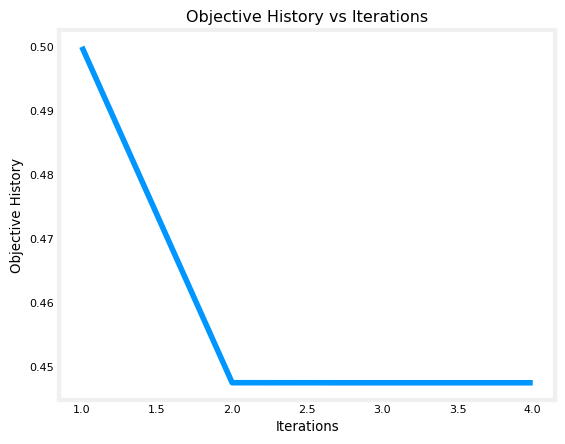

In [65]:
# Get the objective history from the lr_model summary
objective_history = lr_model.summary.objectiveHistory

# Create a list of iterations
iterations = list(range(1, len(objective_history) + 1))

plt.plot(iterations, objective_history)
plt.xlabel('Iterations')
plt.ylabel('Objective History')
plt.title('Objective History vs Iterations')
plt.show()